In [1]:
!pip install pyglet==1.5.0

In [2]:
import sys
import gym
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from collections import deque
from keras.layers import Dense,Activation
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import model_from_json
from Agent import MountainCarAgent
from keras.layers import LeakyReLU
from keras.initializers import he_normal
from keras.initializers import RandomNormal

from keras.optimizers import SGD




Using TensorFlow backend.


In [3]:
# to store rewards in each episode
rewards_per_episode, episodes = [], []


In [4]:
env = gym.make('MountainCar-v0')
env.reset()

array([-0.40551075,  0.        ])

In [5]:
state_size = env.observation_space.shape[0] # equal to 4 in case of cartpole 
action_size = env.action_space.n  

In [6]:
agent = MountainCarAgent(action_size, state_size)

C:\Asheer\anaconda\lib\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [7]:
n_episodes = 40
update_counter = 0
epsilon = 1

In [8]:
#### simulation starts ####
for episode in range(n_episodes):

    done = False
    score = 0
    # reset at the start of each episode
    state = env.reset()

    while not done:
        env.render()

        agent.epsilon = 0.01 + (1 - 0.01) * np.exp(-0.001*update_counter)
        update_counter = update_counter + 1
        # get action for the current state and take a step in the environment
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        reward = 100*((np.sin(3 * next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (np.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] * state[1])) 
        
        if next_state[0] >= 0.5:
            reward += 1
            
        # save the sample <s, a, r, s', done> to the replay memory
        agent.append_sample(state,action, reward, next_state,done)
        
        # train after each step
        agent.train_model()

        # add reward to the total score of this episode
        score += reward
        state = next_state
        if done:
            agent.update_target_model()
        
 


    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # terminate if no major learning for previous 5 episodes
    if np.mean(rewards_per_episode[-5:]) > 1.5 :
        break;
    
    
    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
    # every few episodes:
    if episode > 1 and episode % 5 == 0:
        # save model weights
        agent.save_model_weights(name="model_weights.h5")

#### simulation complete ####


episode 0, reward 0.011481111181025325, memory_length 200, epsilon 0.8213543943995963
episode 1, reward 0.07922157150043421, memory_length 400, epsilon 0.6742807943399114
episode 2, reward 0.2683259116791901, memory_length 600, epsilon 0.5538671150051557
episode 3, reward 0.3488364757701446, memory_length 800, epsilon 0.4552807326425205
episode 4, reward 0.3253255353444607, memory_length 1000, epsilon 0.3745650295675263
episode 5, reward 1.5016522131170298, memory_length 1175, epsilon 0.3160366735973937
episode 6, reward 0.22625593857152332, memory_length 1375, epsilon 0.2605616362438746
episode 7, reward 0.35798486122037093, memory_length 1575, epsilon 0.2151425171343988
episode 8, reward 1.516610624105506, memory_length 1750, epsilon 0.18220832626673847
episode 9, reward 1.5040132668986927, memory_length 1929, epsilon 0.15398439751690954
episode 10, reward 1.5224704350250113, memory_length 2000, epsilon 0.1303862041850159
episode 11, reward 1.5565255963746574, memory_length 2000, eps

In [9]:
# save stuff as pickle
# def save_pickle(obj, name):
#     with open(name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
# save_pickle(rewards_per_episode, "rewards_per_episode")

In [11]:
# plot results
# with open('rewards_per_episode.pkl', 'rb') as f:
#     rewards_per_episode = pickle.load(f)

Text(0, 0.5, 'reward per episode')

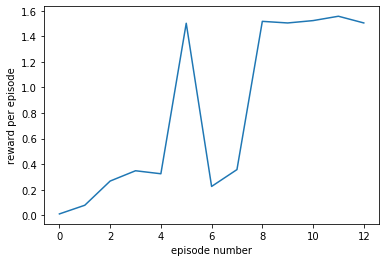

In [12]:
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

In [13]:
print("Average reward of last 100 episodes is {0}".format(np.mean(rewards_per_episode[-100:]))) 


Average reward of last 100 episodes is 0.8248356263630618


In [14]:
def play_game(ml_model, games=10):
    """
    Play te Game
    :param ml_model:
    :param games:
    :return:
    """

    for i_episode in range(games):

        # Define Reward Var
        episode_reward = 0

        # Reset Env for the Game
        observation = env.reset()

        while True:
            render = env.render()

            # Predict Next Movement
            current_action_pred = ml_model.predict(observation.reshape(1, 2))[0]

            # Define Movement
            current_action = np.argmax(current_action_pred)

            # Make Movement
            observation, reward, done, info = env.step(current_action)

            # Update Reward Value
#             episode_reward += compute_reward(observation[[0]])

            if done:
                print(f"Episode finished after {i_episode+1} steps", end='')
                break

In [15]:
def build_model():
    
    
    
    init = he_normal(seed = 1000)
#         init = RandomNormal(mean=0., stddev=1.)
    model = Sequential()
    model.add(Dense(48, input_dim=2,kernel_initializer = init))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(64,kernel_initializer = init))
    model.add(LeakyReLU(alpha=0.1))

#         model.add(Dense(self.action_size, activation=LeakyReLU(alpha=0.1)))
    model.add(Dense(3, activation=LeakyReLU(alpha=0.1),kernel_initializer = init))
    model.compile(loss="mean_squared_error",
              optimizer=Adam(lr = 0.0001))

    return model

In [16]:
mymodel = build_model()
mymodel.load_weights("./model_weights.h5")
play_game(mymodel)

C:\Asheer\anaconda\lib\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Episode finished after 1 stepsEpisode finished after 2 stepsEpisode finished after 3 stepsEpisode finished after 4 stepsEpisode finished after 5 stepsEpisode finished after 6 stepsEpisode finished after 7 stepsEpisode finished after 8 stepsEpisode finished after 9 stepsEpisode finished after 10 steps

In [17]:
def build_model():
    model = Sequential()
    model.add(Dense(64, input_dim=2))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(3, activation=LeakyReLU(alpha=0.1)))
    model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.02))
                
    return model

In [18]:
time = np.arange(0,30000)
epsilon = []
for i in range(0,30000):
    
    epsilon.append(0.01 + (1 - 0.01) * np.exp(-0.0001*i))
#     epsilon.append(0.001 + (1 - 0.001) * np.exp(-0.01*i))

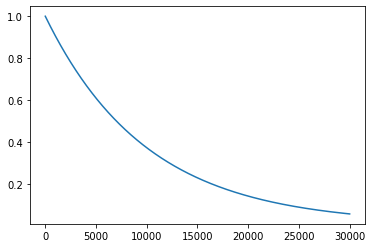

In [19]:
plt.plot(time, epsilon)
plt.show()